# GMM using EM

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from sklearn.mixture import GaussianMixture

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

In [2]:
from sklearn.datasets import fetch_openml

mnist_data = fetch_openml('mnist_784', version=1)
print(mnist_data.keys())
X, y = mnist_data['data'], mnist_data['target']
print('Shape of X:', X.shape, '\n', 'Shape of y:', y.shape)

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])
Shape of X: (70000, 784) 
 Shape of y: (70000,)


In [4]:
print(mnist_data.keys())
X, y = mnist_data['data'], mnist_data['target']
print('Shape of X:', X.shape, '\n', 'Shape of y:', y.shape)

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])
Shape of X: (70000, 784) 
 Shape of y: (70000,)


(-0.5, 27.5, 27.5, -0.5)

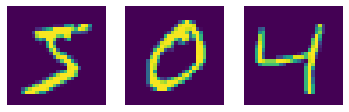

In [11]:
import matplotlib.pyplot as plt
 
digit = X[0]
digit_pixels = digit.reshape(28, 28)
plt.subplot(131)
plt.imshow(digit_pixels)
plt.axis('off')
 
digit = X[1]
digit_pixels = digit.reshape(28, 28)
plt.subplot(132)
plt.imshow(digit_pixels)
plt.axis('off')
 
digit = X[2]
digit_pixels = digit.reshape(28, 28)
plt.subplot(133)
plt.imshow(digit_pixels)
plt.axis('off')

In [34]:
def plot_digits(data):
    sess=tf.compat.v1.Session()
    data1=data.eval(session=sess)
    fig, ax = plt.subplots(5, 5, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data1[i].reshape(28, 28), cmap='plasma')

In [15]:
import random

In [3]:

data = X[np.random.randint(X.shape[0], size=1000), :] ## IMPORTANT BEAUTY

In [4]:
type(data)

numpy.ndarray

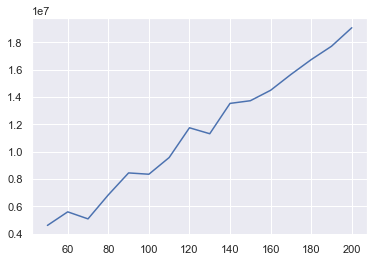

In [32]:
n_components = np.arange(50, 210, 10)
models = [GaussianMixture(n, init_params='kmeans',covariance_type='full', random_state=None) for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);

In [43]:
gmm = GaussianMixture(150, init_params='kmeans',covariance_type='full', random_state=None)
gmm.fit_predict(data)
print(gmm.converged_)

True


In [44]:
data_new_x,data_new_y = gmm.sample(100)
data_new_x,data_new_y

(array([[-3.35111456e-03, -1.37450159e-03, -1.83275116e-03, ...,
          9.12126342e-04,  2.72750015e-04, -9.23330385e-05],
        [-1.41230984e-03, -3.04492236e-03,  5.89939172e-04, ...,
         -6.07432723e-04, -2.15221836e-04, -1.08603500e-03],
        [ 5.17913679e-04,  4.69840841e-04,  1.02572443e-03, ...,
          3.29549488e-04, -3.92504869e-04, -1.11594983e-03],
        ...,
        [ 3.93656952e-04, -9.28219060e-05,  2.95483402e-04, ...,
          8.89849660e-04, -9.67328087e-04, -3.33667294e-04],
        [ 1.31063510e-03, -1.50847917e-03, -2.12279693e-03, ...,
          9.09298638e-04, -7.46688045e-04, -6.05511893e-04],
        [ 1.12902281e-03,  4.21205364e-05, -9.78753443e-05, ...,
         -2.43973931e-03,  1.15358564e-03,  8.44388132e-04]]),
 array([  0,   1,   3,   5,   5,   6,   8,   8,   9,  15,  15,  15,  15,
         15,  16,  21,  24,  26,  27,  27,  27,  33,  34,  35,  37,  38,
         40,  40,  40,  42,  43,  44,  44,  46,  48,  48,  48,  49,  51,
         5

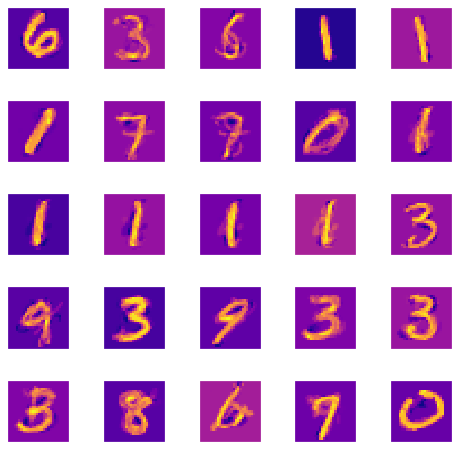

In [46]:

plot_digits(data_new_x)

# VARIATIONAL ENCODER( PREDEFINED LATENT SPACE)

In [10]:
'''
  Variational Autoencoder (VAE) with the Keras Functional API.
'''

import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras.layers import BatchNormalization
from keras.models import Model
from keras.datasets import mnist
from keras.losses import binary_crossentropy
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

m = 50
n_z = 2
n_epoch = 10


# Q(z|X) -- encoder
inputs = Input(shape=(784,))
h_q = Dense(512, activation='relu')(inputs)
mu = Dense(n_z, activation='linear')(h_q)
log_sigma = Dense(n_z, activation='linear')(h_q)

def sample_z(args):
    mu, log_sigma = args
    eps = K.random_normal(shape=(m, n_z), mean=0., stddev=1.)
    return mu + K.exp(log_sigma / 2) * eps


# Sample z ~ Q(z|X)
z = Lambda(sample_z)([mu, log_sigma])

# P(X|z) -- decoder
decoder_hidden = Dense(512, activation='relu')
decoder_out = Dense(784, activation='sigmoid')

h_p = decoder_hidden(z)
outputs = decoder_out(h_p)


# Overall VAE model, for reconstruction and training
vae = Model(inputs, outputs)

# Encoder model, to encode input into latent variable
# We use the mean as the output as it is the center point, the representative of the gaussian
encoder = Model(inputs, mu)

# Generator model, generate new data given latent variable z
d_in = Input(shape=(n_z,))
d_h = decoder_hidden(d_in)
d_out = decoder_out(d_h)
decoder = Model(d_in, d_out)


def vae_loss(y_true, y_pred):
    """ Calculate loss = reconstruction loss + KL loss for each data in minibatch """
    # E[log P(X|z)]
    recon = K.sum(K.binary_crossentropy(y_pred, y_true), axis=1)
    # D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
    kl = 0.5 * K.sum(K.exp(log_sigma) + K.square(mu) - 1. - log_sigma, axis=1)

    return recon + kl


vae.compile(optimizer='adam', loss=vae_loss)
vae.fit(X, X, batch_size=m, nb_epoch=n_epoch)




Train on 70000 samples
Epoch 1/10
70000/70000 [==============================] - 7s 104us/sample - loss: nan
Epoch 2/10
70000/70000 [==============================] - 7s 101us/sample - loss: nan
Epoch 3/10
70000/70000 [==============================] - 7s 101us/sample - loss: nan
Epoch 4/10
70000/70000 [==============================] - 7s 101us/sample - loss: nan
Epoch 5/10
70000/70000 [==============================] - 7s 101us/sample - loss: nan
Epoch 6/10
70000/70000 [==============================] - 7s 102us/sample - loss: nan
Epoch 7/10
70000/70000 [==============================] - 7s 101us/sample - loss: nan
Epoch 8/10
70000/70000 [==============================] - 7s 102us/sample - loss: nan
Epoch 9/10
70000/70000 [==============================] - 7s 101us/sample - loss: nan
Epoch 10/10
70000/70000 [==============================] - 7s 101us/sample - loss: nan


# Detailed VAE

In [5]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
import numpy as np
import glob
import matplotlib as mp

In [6]:
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras.layers import BatchNormalization
from keras.models import Model
from keras.datasets import mnist
from keras.losses import binary_crossentropy
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


Instructions for updating:
non-resource variables are not supported in the long term


In [12]:
(input_train, target_train), (input_test, target_test) = mnist.load_data()


In [13]:
np.shape(input_train)

(60000, 28, 28)

In [14]:
np.shape(input_train[:2000])

(2000, 28, 28)

In [19]:
# Data & model configuration
img_width, img_height = input_train.shape[1], input_train.shape[2]
batch_size = 28
no_epochs = 5
validation_split = 0.2
verbosity = 1
latent_dim = 2
num_channels = 1

In [20]:
# Reshape data
input_train = input_train.reshape(input_train.shape[0], img_height, img_width, num_channels)
input_test = input_test.reshape(input_test.shape[0], img_height, img_width, num_channels)
input_shape = (img_height, img_width, num_channels)

# Parse numbers as floats
input_train = input_train.astype('float32')
input_test = input_test.astype('float32')

# Normalize data
input_train = input_train / 255
input_test = input_test / 255

### ENCODER

In [22]:
# Definition
i       = Input(shape=input_shape, name='encoder_input')
cx      = Conv2D(filters=8, kernel_size=3, strides=2, padding='same', activation='relu',kernel_initializer='he_uniform')(i)
cx1      = BatchNormalization()(cx)
cx2      = Conv2D(filters=16, kernel_size=3, strides=2, padding='same', activation='relu',kernel_initializer='he_uniform')(cx1)
cx3      = BatchNormalization()(cx2)
x       = Flatten()(cx3)
x1       = Dense(20, activation='relu')(x)
x2       = BatchNormalization()(x1)
mu      = Dense(latent_dim, name='latent_mu')(x)
sigma   = Dense(latent_dim, name='latent_sigma')(x)

In [24]:
# Get Conv2D shape for Conv2DTranspose operation in decoder
conv_shape = K.int_shape(cx3)

### Reparameterization 

In [25]:
# Define sampling with reparameterization trick
def sample_z(args):
  mu, sigma = args
  batch     = K.shape(mu)[0]
  dim       = K.int_shape(mu)[1]
  eps       = K.random_normal(shape=(batch, dim))
  return mu + K.exp(sigma / 2) * eps

### Reparameterization to ensure smooth gradients.

In [26]:
z  = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([mu, sigma])

In [27]:
sigma

<tf.Tensor 'latent_sigma/BiasAdd:0' shape=(?, 2) dtype=float32>

### Instantiate Encoder

In [28]:
encoder = Model(i, [mu, sigma, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 8)    80          encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 14, 14, 8)    32          conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 7, 7, 16)     1168        batch_normalization_1[0][0]      
____________________________________________________________________________________________

## DECODER

In [29]:
# Definition
d_i   = Input(shape=(latent_dim, ), name='decoder_input')
x     = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(d_i)
x1     = BatchNormalization()(x)
x2     = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x1)
cx    = Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same', activation='relu',kernel_initializer='he_uniform')(x2)
cx1    = BatchNormalization()(cx)
cx2    = Conv2DTranspose(filters=8, kernel_size=3, strides=2, padding='same',  activation='relu',kernel_initializer='he_uniform')(cx1)
cx3    = BatchNormalization()(cx2)
o1     = Conv2DTranspose(filters=num_channels, kernel_size=3, activation='sigmoid', padding='same',kernel_initializer='he_uniform', name='decoder_output')(cx3)

### Instantiate decoder

In [30]:
# Instantiate decoder
decoder = Model(d_i, o1, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 784)               2352      
_________________________________________________________________
batch_normalization_4 (Batch (None, 784)               3136      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 16)        2320      
_________________________________________________________________
batch_normalization_5 (Batch (None, 14, 14, 16)        64        
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 8)         1160

# VAE 

In [31]:
# =================
# VAE as a whole
# =================

# Instantiate VAE
vae_outputs = decoder(encoder(i)[2])
vae         = Model(i, vae_outputs, name='vae')
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 4484      
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         9137      
Total params: 13,621
Trainable params: 11,957
Non-trainable params: 1,664
_________________________________________________________________


### LOSS = RECONSTRUCTION + KL DIVERGENCE

In [32]:
# Define loss
def kl_reconstruction_loss(true, pred):
  # Reconstruction loss
  reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height
  # KL divergence loss
  kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
  kl_loss = K.sum(kl_loss, axis=-1)
  kl_loss *= -0.5
  # Total loss = 50% rec + 50% KL divergence loss
  return K.mean(reconstruction_loss + kl_loss)

## COMPILATION AND TRAINING

In [33]:
# Compile VAE
vae.compile(optimizer='adam', loss=kl_reconstruction_loss, experimental_run_tf_function=False)

# Train autoencoder
vae.fit(input_train[:20000], input_train[:20000], epochs = no_epochs, batch_size = batch_size, validation_split = validation_split)

Train on 16000 samples, validate on 4000 samples
Epoch 1/5
16000/16000 [==============================] - 3s 209us/sample - loss: 298.1214 - val_loss: 189.3982
Epoch 2/5
16000/16000 [==============================] - 3s 198us/sample - loss: 181.8514 - val_loss: 176.7073
Epoch 3/5
16000/16000 [==============================] - 3s 196us/sample - loss: 175.6225 - val_loss: 173.0194
Epoch 4/5
16000/16000 [==============================] - 3s 195us/sample - loss: 172.9735 - val_loss: 172.5435
Epoch 5/5
16000/16000 [==============================] - 3s 196us/sample - loss: 170.9900 - val_loss: 168.9277


## Visualizing VAE results


### LATENT SPACE

In [34]:
# =================
# Results visualization
# Credits for original visualization code: https://keras.io/examples/variational_autoencoder_deconv/
# (François Chollet).
# Adapted to accomodate this VAE.
# =================
def viz_latent_space(encoder, data):
  input_data, target_data = data
  mu, _, _ = encoder.predict(input_data)
  plt.figure(figsize=(8, 10))
  plt.scatter(mu[:, 0], mu[:, 1], c=target_data)
  plt.xlabel('z - dim 1')
  plt.ylabel('z - dim 2')
  plt.colorbar()
  plt.show()

## Samples FROM LATENT SPACE

In [35]:
def viz_decoded(encoder, decoder, data):
  num_samples = 15
  figure = np.zeros((img_width * num_samples, img_height * num_samples, num_channels))
  grid_x = np.linspace(-4, 4, num_samples)
  grid_y = np.linspace(-4, 4, num_samples)[::-1]
  for i, yi in enumerate(grid_y):
      for j, xi in enumerate(grid_x):
          z_sample = np.array([[xi, yi]])
          x_decoded = decoder.predict(z_sample)
          digit = x_decoded[0].reshape(img_width, img_height, num_channels)
          figure[i * img_width: (i + 1) * img_width,
                  j * img_height: (j + 1) * img_height] = digit
  plt.figure(figsize=(10, 10))
  start_range = img_width // 2
  end_range = num_samples * img_width + start_range + 1
  pixel_range = np.arange(start_range, end_range, img_width)
  sample_range_x = np.round(grid_x, 1)
  sample_range_y = np.round(grid_y, 1)
  plt.xticks(pixel_range, sample_range_x)
  plt.yticks(pixel_range, sample_range_y)
  plt.xlabel('z - dim 1')
  plt.ylabel('z - dim 2')
  # matplotlib.pyplot.imshow() needs a 2D array, or a 3D array with the third dimension being of shape 3 or 4!
  # So reshape if necessary
  fig_shape = np.shape(figure)
  if fig_shape[2] == 1:
    figure = figure.reshape((fig_shape[0], fig_shape[1]))
  # Show image
  plt.imshow(figure)
  plt.show()

### CALLING VISUALIZERS

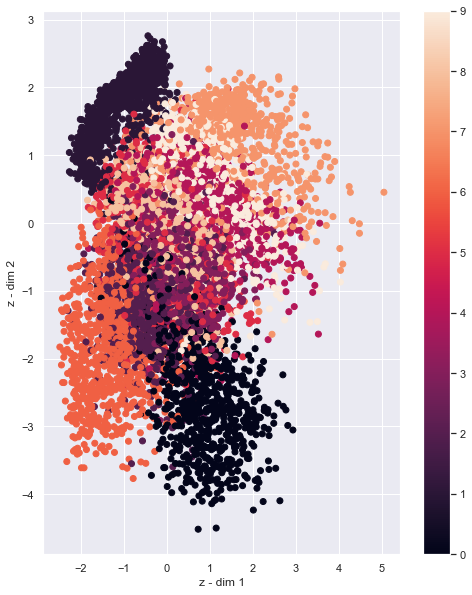

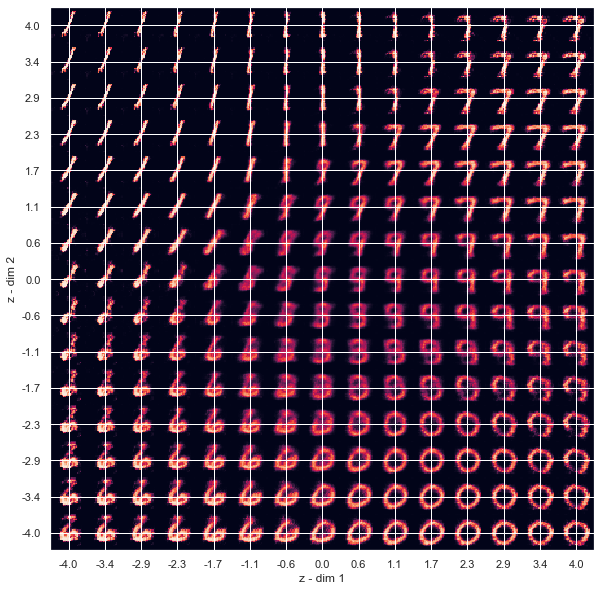

In [36]:
# Plot results
data = (input_test, target_test)
viz_latent_space(encoder, data)
viz_decoded(encoder, decoder, data)

## Other Possible code! Testing.

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 31us/sample - loss: 191.2424 - val_loss: 172.2139
Epoch 2/50
60000/60000 [==============================] - 2s 29us/sample - loss: 169.7919 - val_loss: 167.7809
Epoch 3/50
60000/60000 [==============================] - 2s 29us/sample - loss: 166.7775 - val_loss: 165.8155
Epoch

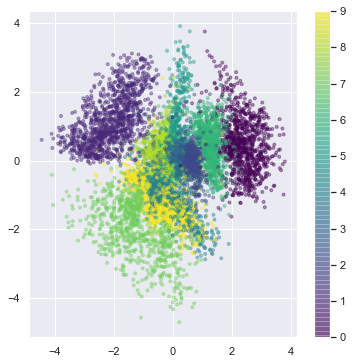

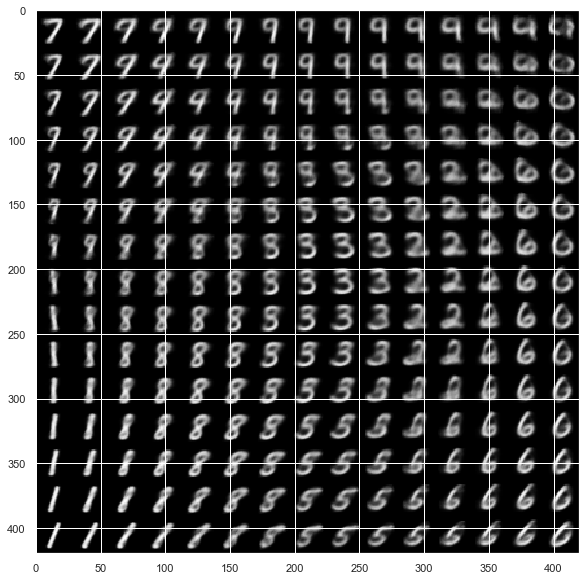

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras import backend as K

from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential
from keras.datasets import mnist


original_dim = 784
intermediate_dim = 256
latent_dim = 2
batch_size = 100
epochs = 50
epsilon_std = 1.0


def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    
    
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)


class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs


decoder = Sequential([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(original_dim, activation='sigmoid')
])

x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

eps = Input(tensor=K.random_normal(stddev=epsilon_std,
                                   shape=(K.shape(x)[0], latent_dim)))
z_eps = Multiply()([z_sigma, eps])
z = Add()([z_mu, z_eps])

x_pred = decoder(z)

vae = Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='rmsprop', loss=nll)

# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, original_dim) / 255.
x_test = x_test.reshape(-1, original_dim) / 255.

vae.fit(x_train,
        x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

encoder = Model(x, z_mu)



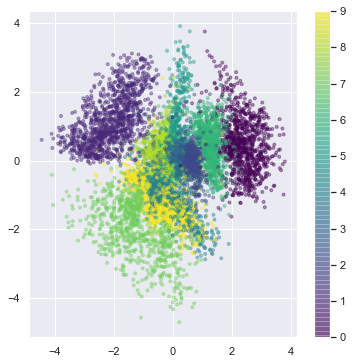

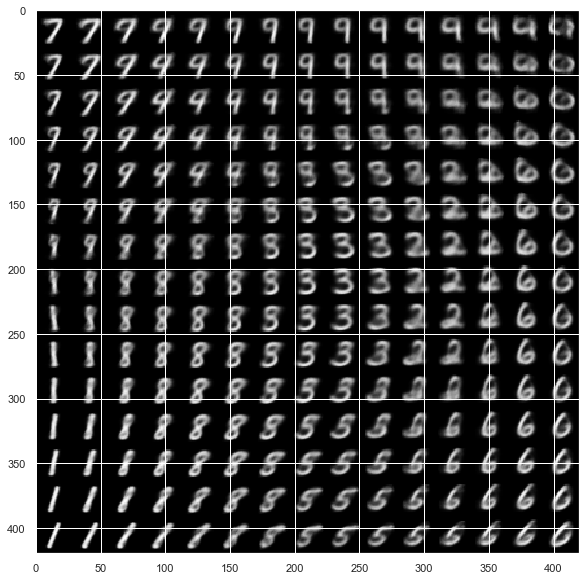

In [46]:
# display a 2D plot of the digit classes in the latent space
z_test = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test,
            alpha=.4, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28




u_grid = np.dstack(np.meshgrid(np.linspace(0.05, 0.95, n),
                               np.linspace(0.05, 0.95, n)))
z_grid = norm.ppf(u_grid)
x_decoded = decoder.predict(z_grid.reshape(n*n, 2))
x_decoded = x_decoded.reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_decoded))), cmap='gray')
plt.show()